# Convolutional Network Classifier
Minimal convolutional network to classify Fashion MNIST

In [ ]:
# Viz imports
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

import sys
import os

# Numpy
import numpy as np
from skimage import color, io

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Torchvision
import torchvision.utils
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Dataset
from torchvision.datasets import FashionMNIST

## Training params

In [ ]:
num_epochs = 20
batch_size = 128
learning_rate = 1e-3
use_dropout = True
use_gpu = True

## Fashion MNIST Dataset

60,000 images in 10 clothing categories: Top/T-shirt, Trouser, Pullover, Dress, Coat, Sandar, Shirt, Sneaker, Bag, Anckle Boot. We normalize the dataset.

In [3]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # image = (image - mean) / std
])

train_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

100.0%


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



tensor([7, 1, 8, 1, 8, 7, 6, 6, 3, 3, 2, 8, 2, 2, 2, 2, 5, 7, 9, 6, 4, 5, 1, 3,
        7, 7, 4, 0, 8, 4, 9, 0, 4, 3, 5, 6, 6, 7, 5, 2, 9, 9, 7, 9, 2, 2, 5, 3,
        0, 6, 2, 0, 5, 0, 7, 4, 0, 2, 8, 5, 0, 5, 4, 8, 4, 2, 4, 7, 5, 9, 7, 6,
        4, 5, 9, 6, 1, 9, 7, 1, 0, 5, 4, 8, 7, 4, 6, 1, 0, 4, 3, 2, 1, 1, 6, 4,
        1, 2, 0, 1, 7, 2, 4, 3, 9, 9, 8, 5, 9, 5, 0, 6, 3, 9, 8, 0, 5, 1, 1, 3,
        6, 1, 2, 5, 7, 7, 5, 3])


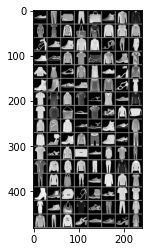

In [4]:
# Some random imgs
def imshow(img):
    img = img / 2 + 0.5
    img = img.numpy()
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show
    
samples = enumerate(train_dataloader)
batch_idx, (sample_data, sample_targets) = next(samples)
imshow(torchvision.utils.make_grid(sample_data))
print(sample_targets)

## CNN

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, kernel_size=4, stride=2, padding=1) # out: 8 x 14 x 14
        self.conv2 = nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1) # out: 16 x 7 x 7
        self.conv3 = nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 3 x 3
        if use_dropout:
            self.do1 = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(288, 50)
        if use_dropout:
            self.do2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(50, 10) # 10 outputs

    def forward(self, x):
        # convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        if use_dropout:
            x = self.do1(x)
        x = x.view(x.size(0), -1) # features maps to feature vectors
        
        # fully connected layers
        x = F.relu(self.fc1(x))
        if use_dropout:
            x = self.do2(x)
        
        #act = nn.LogSoftmax(dim=1)
        x = self.fc2(x) #softmax activation
        
        return x

convnet = ConvNet()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
convnet = convnet.to(device)

num_params = sum(p.numel() for p in convnet.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 25384


## Training Loop

In [6]:
# Optimizer
optimizer = torch.optim.Adam(params=convnet.parameters(), lr=learning_rate)

# Training mode
convnet.train()

train_loss_avg = []

# loss function (Cross Entropy)
criterion = nn.CrossEntropyLoss()

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, label_batch in train_dataloader:
        
        # Get image data and labels
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)
        
        # Predict
        prediction_batch = convnet(image_batch)
        
        # Compute loss
        loss = criterion(prediction_batch, label_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # optimizer step
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 20] average loss: 0.979654
Epoch [2 / 20] average loss: 0.654484
Epoch [3 / 20] average loss: 0.590841
Epoch [4 / 20] average loss: 0.547537
Epoch [5 / 20] average loss: 0.523137
Epoch [6 / 20] average loss: 0.500195
Epoch [7 / 20] average loss: 0.485781
Epoch [8 / 20] average loss: 0.471546
Epoch [9 / 20] average loss: 0.460537
Epoch [10 / 20] average loss: 0.449604
Epoch [11 / 20] average loss: 0.443011
Epoch [12 / 20] average loss: 0.433261
Epoch [13 / 20] average loss: 0.426941
Epoch [14 / 20] average loss: 0.423766
Epoch [15 / 20] average loss: 0.413935
Epoch [16 / 20] average loss: 0.407842
Epoch [17 / 20] average loss: 0.405282
Epoch [18 / 20] average loss: 0.398483
Epoch [19 / 20] average loss: 0.392323
Epoch [20 / 20] average loss: 0.388321


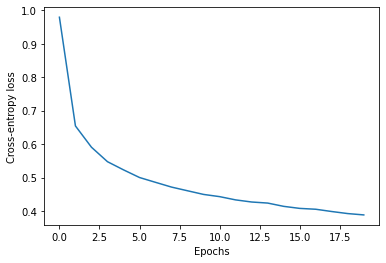

In [7]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Cross-entropy loss')
plt.show()

## Evaluation

In [8]:
# Eval. mode
convnet.eval()

num_incorrect = 0
test_loss_avg = 0
num_batches = 0
num_instances = 0
for image_batch, label_batch in test_dataloader:
    
    with torch.no_grad():

        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)

        # predicciones
        prediction_batch = convnet(image_batch)

        # Contamos la cantidad de predicciones correctas
        _, predicted_label = prediction_batch.max(dim=1)
        num_incorrect += (predicted_label != label_batch).sum().item()

        # cross-entropy 
        loss = criterion(prediction_batch, label_batch)

        test_loss_avg += loss.item()
        num_batches += 1
        num_instances += image_batch.size(0)
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))
print('classification error: %f%%' % ((num_incorrect / num_instances)*100))

average loss: 0.332046
classification error: 12.180000%


tensor([3, 1, 1, 0, 4, 5, 4, 2, 3, 7, 2, 2, 4, 5, 0, 4, 0, 7, 8, 3, 6, 6, 4, 7,
        5, 0, 4, 6, 1, 6, 5, 1, 4, 0, 3, 4, 8, 8, 5, 0, 1, 5, 6, 3, 4, 9, 0, 4,
        1, 6, 0, 4, 9, 1, 0, 7, 0, 3, 2, 8, 7, 1, 2, 4, 3, 2, 2, 9, 3, 8, 2, 7,
        8, 7, 8, 5, 8, 9, 2, 5, 6, 1, 9, 5, 7, 9, 1, 6, 8, 4, 2, 2, 8, 9, 3, 0,
        9, 1, 4, 2, 5, 8, 6, 8, 8, 0, 8, 5, 9, 5, 3, 8, 6, 1, 2, 2, 2, 9, 4, 5,
        3, 8, 5, 8, 8, 4, 2, 6])
tensor([3, 1, 1, 0, 3, 5, 4, 2, 3, 7, 2, 2, 4, 5, 0, 4, 0, 7, 8, 3, 4, 6, 2, 7,
        5, 0, 4, 6, 1, 6, 5, 1, 4, 0, 8, 4, 8, 8, 5, 0, 1, 5, 0, 3, 4, 9, 0, 4,
        3, 6, 0, 4, 9, 1, 6, 9, 0, 3, 2, 8, 7, 1, 2, 4, 3, 2, 4, 9, 3, 8, 2, 7,
        8, 7, 8, 5, 8, 9, 4, 5, 6, 1, 9, 5, 7, 9, 1, 0, 8, 4, 2, 2, 8, 9, 0, 0,
        9, 1, 4, 2, 5, 8, 2, 8, 8, 0, 8, 5, 9, 5, 3, 8, 4, 1, 2, 2, 4, 9, 4, 5,
        3, 8, 5, 8, 8, 2, 2, 6], device='cuda:0')


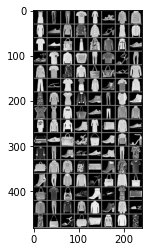

In [10]:
# Verificar predicciones en imágenes random
samples = enumerate(test_dataloader)
batch_idx, (sample_data, sample_targets) = next(samples)

prediction_batch = convnet(sample_data.to(device))
_, predicted_label = prediction_batch.max(dim=1)

imshow(torchvision.utils.make_grid(sample_data))
print(sample_targets)
print(predicted_label)